In [4]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
import optuna

In [5]:
# импортируем данные и смотрим, как они выглядят
data = pd.read_csv('data/_train_sem09 (1).csv')
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


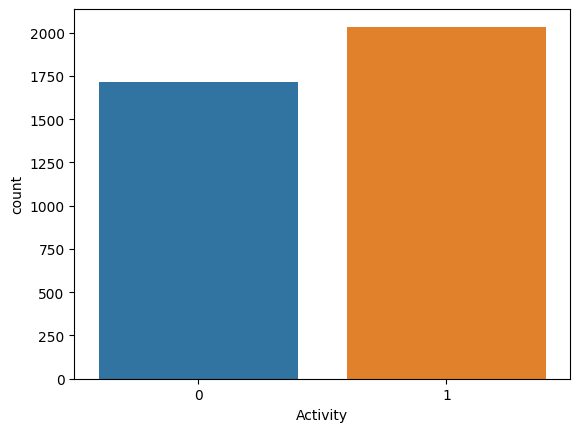

In [6]:
# проверяем сбалансированность классов
sns.countplot(data=data, x='Activity');

Классы сбалансированы, поэтому не будем включать параметр stratify при разбиении выборки

In [7]:
# создаем матрицу наблюдений X и правильных ответов y
# делим выборку на тренировочную и тестовою 70/30
# заодно закладываем параметр random_state на все задания
X = data.drop(['Activity'], axis=1)
y = data['Activity']
random_state = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = random_state, test_size = 0.3)

Данные готовы к работе.  
### **GridSearchCV**  
Сначала на модели логистической регрессии

In [203]:
# задаем сетку параметров
param_grid = [{'penalty': ['l2', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}, # уровень силы регурялизации 
              {'penalty': ['l1', 'l2'],
              'solver': ['liblinear', 'saga'],
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}]

# задаем перебор гиперпараметров на модели логистической регрессии
grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=random_state, #генератор случайных чисел
        max_iter=1000 #количество итераций на сходимость 
    ), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test, y_test)))
y_test_pred = grid_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

CPU times: total: 33.5 s
Wall time: 53min 30s
accuracy на тестовом наборе: 0.77
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}


**Случайный лес**

In [204]:

param_grid = {'min_samples_leaf': list(np.linspace(2, 10, 3, dtype=int)),
              'max_depth': list(np.linspace(15, 26, 3, dtype=int)),
              'n_estimators': list(np.linspace(100, 200, 3, dtype=int))}

grid_search_tree = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=random_state), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
    )  
%time grid_search_tree.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_tree.score(X_test, y_test)))
y_test_pred = grid_search_tree.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_tree.best_params_))

CPU times: total: 6.53 s
Wall time: 3min 13s
accuracy на тестовом наборе: 0.80
f1_score на тестовом наборе: 0.82
Наилучшие значения гиперпараметров: {'max_depth': 15, 'min_samples_leaf': 2, 'n_estimators': 150}


**Вывод**  
Перебор параметров занимает длительное время.
Метрика f1 на модели логистической регрессии равна 0.79 при полученных лучших гиперпараметрах модели - 'C': 0.1, 'penalty': 'l2', 'solver': 'saga'.  
Метрика f1 на модели случайного дерева лучше - 0.82. Гиперпараметры: 'max_depth': 15, 'min_samples_leaf': 2, 'n_estimators': 150

### **RandomizedSearchCV**  
**Логистическая регрессия**

In [205]:
# для чистоты эксперимента используем те же сетки параметров и те же модели
param_distributions = [{'penalty': ['l2', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}, # уровень силы регурялизации 
              {'penalty': ['l1', 'l2'],
              'solver': ['liblinear', 'saga'],
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}]

random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=random_state, max_iter=1000), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 20, 
    n_jobs = -1
)  
%time random_search.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(random_search.score(X_test, y_test)))
y_test_pred = random_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

CPU times: total: 35.8 s
Wall time: 22min 53s
accuracy на тестовом наборе: 0.77
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'solver': 'saga', 'penalty': 'l2', 'C': 0.1}


**Случайный лес**

In [206]:
param_distributions = {'min_samples_leaf': list(np.linspace(2, 10, 3, dtype=int)),
              'max_depth': list(np.linspace(15, 26, 3, dtype=int)),
              'n_estimators': list(np.linspace(100, 200, 3, dtype=int))}


random_search_tree = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=random_state), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter = 20, 
    n_jobs = -1
)  
%time random_search_tree.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(random_search_tree.score(X_test, y_test)))
y_test_pred = random_search_tree.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_tree.best_params_))

CPU times: total: 4.86 s
Wall time: 2min 30s
accuracy на тестовом наборе: 0.80
f1_score на тестовом наборе: 0.82
Наилучшие значения гиперпараметров: {'n_estimators': 150, 'min_samples_leaf': 2, 'max_depth': 15}


**Выводы**  
На модели логистической регрессии при случайном подборе параметров получилась такая же метрика и такой же набор гиперпараметров при вдвое меньших затратах времени.

На модели случайного и случайном выборе гиперпараметров значение метрики то же самое ,что и при сплошном переборе - 0,82. Гиперпараметры те же самые. Времени потрачено на 30% меньше.

### **Hyperopt**  
**Логистическая регрессия**

In [8]:
# зададим пространство поиска гиперпараметров и совместимость гиперпараметров
penalty_list = ['l1', 'l2', None]
solver_list = ['lbfgs', 'sag', 'liblinear', 'saga']
compatibilyty_dict = {'lbfgs': ['l2', None],
                      'sag': ['l2', None],
                      'liblinear': ['l1', 'l2'],
                      'saga': ['l1', 'l2', None]
                      }

space = {'penalty': hp.choice('penalty', penalty_list),
         'solver': hp.choice('solver', solver_list),
         'C': hp.uniform('C', 0.01, 1)
         }

In [9]:
def hyperopt_lr(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'penalty': str(params['penalty']),
              'solver': str(params['solver']),
              'C': float(params['C'])
              }

    if params['penalty'] not in compatibilyty_dict[params['solver']]:
        return 0
  
    # используем эту комбинацию для построения модели
    model = linear_model.LogisticRegression(**params, random_state=random_state, max_iter = 1000)

    # обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [10]:
%%time
# начинаем подбор гиперпараметров

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_lr, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

 10%|█         | 2/20 [02:10<19:37, 65.43s/trial, best loss: -0.8581411600279524]

c:\Users\u1\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 50%|█████     | 10/20 [04:35<04:07, 24.70s/trial, best loss: -0.8660370759006646]

c:\Users\u1\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 95%|█████████▌| 19/20 [06:45<00:25, 25.50s/trial, best loss: -0.8692604276200491]

c:\Users\u1\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



100%|██████████| 20/20 [06:49<00:00, 20.47s/trial, best loss: -0.8876404494382022]
Наилучшие значения гиперпараметров {'C': 0.7159140762992834, 'penalty': 1, 'solver': 0}
CPU times: total: 6min 42s
Wall time: 6min 49s


In [13]:
# рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(
    penalty = penalty_list[best['penalty']],
    solver = solver_list[best['solver']],
    C = float(best['C']),
    max_iter = 1000,
    random_state = random_state
)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.89
accuracy на тестовом наборе: 0.77
f1_score на тестовом наборе: 0.79


**Случайный лес**

In [211]:
# зададим пространство поиска гиперпараметров
space={'n_estimators': hp.quniform('n_estimators', 100, 200, 1),
       'max_depth' : hp.quniform('max_depth', 15, 26, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1)
      }


In [212]:
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    # score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [213]:
%%time
# начинаем подбор гиперпараметров

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 20/20 [01:12<00:00,  3.63s/trial, best loss: -0.9875842497339483]
Наилучшие значения гиперпараметров {'max_depth': 18.0, 'min_samples_leaf': 2.0, 'n_estimators': 103.0}
CPU times: total: 1min 8s
Wall time: 1min 12s


In [214]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.99
accuracy на тестовом наборе: 0.79
f1_score на тестовом наборе: 0.81


**Выводы**
На логистической регрессии метрика не изменилась. Затраты времени сократились еще втрое. Изменился набор гиперпараметров. В этой библиотеке они интерпретируются иначе, индексом в списке.

Показатели случайного леса снизились на одну десятую, и изменился набор гиперпараметров. Алгоритм не подобрал оптимальный набор при 20 итерациях. Зато время сократилось до 1-й минуты.

### **Optuna**  
**Логистическая регрессия**

In [215]:
# зададим пространство поиска гиперпараметров и совместимость гиперпараметров
penalty_list = ['l1', 'l2', None]
solver_list = ['lbfgs', 'sag', 'liblinear', 'saga']
compatibilyty_dict = {'lbfgs': ['l2', None],
                      'sag': ['l2', None],
                      'liblinear': ['l1', 'l2'],
                      'saga': ['elasticnet', 'l1', 'l2', None]
                      }

space = {'penalty': hp.choice('penalty', penalty_list),
         'solver': hp.choice('solver', solver_list),
         'C': hp.uniform('C', 0.01, 1)
         }

In [216]:
def optuna_log(trial):
    C_value = trial.suggest_float('C', 0.01, 1, log = False)
    penalty_name = trial.suggest_categorical('penalty', penalty_list)
    solver_name = trial.suggest_categorical('solver', solver_list)

    if penalty_name not in compatibilyty_dict[solver_name]:
        return 0
  
    if penalty_name is None:    
        model = linear_model.LogisticRegression(
            penalty = penalty_name,
            max_iter = 1000,
            random_state = random_state
            )
    else:
        model = linear_model.LogisticRegression(
            penalty = penalty_name,
            solver = solver_name,
            C = C_value,
            max_iter = 1000,
            random_state = random_state
            )  
  
    model.fit(X_train, y_train)
  
    score = cross_val_score(model, X_train, y_train, cv = 5, scoring = "f1", n_jobs = -1).mean()
  
    return score

In [217]:
study = optuna.create_study(study_name="LogisticRegression", direction="maximize")

study.optimize(optuna_log, n_trials=20)
print("Best parameters: {}".format(study.best_params))

model = linear_model.LogisticRegression(
    **study.best_params,
    max_iter = 1000,
    random_state = random_state
    )

model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

[I 2023-08-21 17:11:53,487] A new study created in memory with name: LogisticRegression


[I 2023-08-21 17:12:02,811] Trial 0 finished with value: 0.7640612185939148 and parameters: {'C': 0.4115450266177299, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 0 with value: 0.7640612185939148.
[I 2023-08-21 17:14:08,209] Trial 1 finished with value: 0.7653339376804273 and parameters: {'C': 0.37356986259045344, 'penalty': 'l2', 'solver': 'sag'}. Best is trial 1 with value: 0.7653339376804273.
[I 2023-08-21 17:15:54,017] Trial 2 finished with value: 0.7616882617306006 and parameters: {'C': 0.7666032646325585, 'penalty': 'l2', 'solver': 'sag'}. Best is trial 1 with value: 0.7653339376804273.
[I 2023-08-21 17:18:42,580] Trial 3 finished with value: 0.7643772775354657 and parameters: {'C': 0.7185156746857603, 'penalty': 'l2', 'solver': 'saga'}. Best is trial 1 with value: 0.7653339376804273.
[I 2023-08-21 17:18:47,157] Trial 4 finished with value: 0.7745542374961968 and parameters: {'C': 0.7997417630367816, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 4 with value: 0

Best parameters: {'C': 0.11620784192551668, 'penalty': 'l2', 'solver': 'sag'}
f1_score на обучающем наборе: 0.85
accuracy на тестовом наборе: 0.77
f1_score на тестовом наборе: 0.79


**Случайный лес**

In [218]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 15, 26, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score

In [219]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2023-08-21 17:31:38,601] A new study created in memory with name: RandomForestClassifier


[I 2023-08-21 17:31:42,488] Trial 0 finished with value: 0.9121813031161473 and parameters: {'n_estimators': 173, 'max_depth': 24, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.9121813031161473.
[I 2023-08-21 17:31:45,357] Trial 1 finished with value: 0.8954802259887006 and parameters: {'n_estimators': 104, 'max_depth': 26, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.9121813031161473.
[I 2023-08-21 17:31:48,958] Trial 2 finished with value: 0.9466242488511841 and parameters: {'n_estimators': 147, 'max_depth': 15, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.9466242488511841.
[I 2023-08-21 17:31:52,792] Trial 3 finished with value: 0.9216034054629301 and parameters: {'n_estimators': 176, 'max_depth': 15, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.9466242488511841.
[I 2023-08-21 17:31:55,472] Trial 4 finished with value: 0.893210749646393 and parameters: {'n_estimators': 138, 'max_depth': 15, 'min_samples_leaf': 10}. Best is trial 2 with value: 0.94

CPU times: total: 1min 5s
Wall time: 1min 8s


In [220]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 103, 'max_depth': 22, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.99


In [221]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.79
f1_score на тестовом наборе: 0.81


**Вывод**  
На модели Логистической регрессии затраченное время составило более 19 минут. Набор гиперпараметров 'C': 0.11620784192551668, 'penalty': 'l2', 'solver': 'sag'. А метрика f1 - те же 0,79.

На модели случайного леса метрика составила 0,81. А затраченное время - чуть более минуты.

# **Общий вывод**  
Модель случайного леса показала более высокие метрики во всех методах подбора гиперпараметров.

В модели логистической регрессии, напротив, метрики везде одинаковые, и тут следует уделить внимание потраченному времени, особенно на слабых компьютерах.

В модели случайного леса продвинутые методы оптимизации показали себя не с лучшей стороны в части максимальной метрики. Сплошной или случайный перебор оказался надежнее.